In [1]:
!python --version
!pip --version
# Tested on Python 3.9.7
# Tested on Pip 21.3.1

Python 3.9.7
pip 22.0.3 from /home/raja-faizan-nazir/.local/lib/python3.9/site-packages/pip (python 3.9)


In [2]:
!pip show opencv-python
# Tested on Cv2 Version 4.5.5.62

Name: opencv-python
Version: 4.5.5.62
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: 
Author-email: 
License: MIT
Location: /home/raja-faizan-nazir/.local/lib/python3.9/site-packages
Requires: numpy, numpy, numpy
Required-by: 


## 1. Loading test images

In [3]:
#Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip

%matplotlib inline

In [4]:
def list_images(images, cols = 2, rows = 5, cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: List of np.arrays compatible with plt.imshow.
            cols (Default = 2): Number of columns in the figure.
            rows (Default = 5): Number of rows in the figure.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap = cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

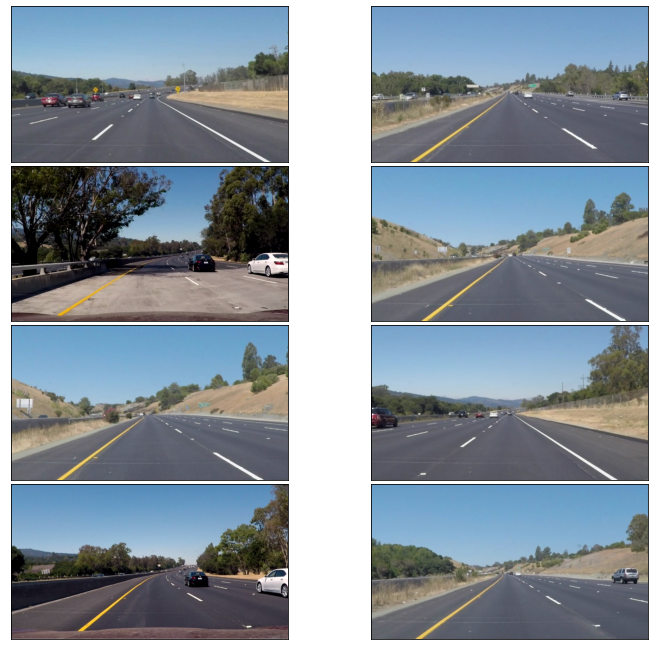

In [5]:
#Reading in the test images
test_images = [plt.imread(img) for img in glob.glob('test_images/*.jpg')]
list_images(test_images)

### Original RGB color selection

I will apply color selection to the `test_images` in the original RGB format. We will try to retain as much of the lane lines as possible, while blacking out most of the other stuff.

In [6]:
def RGB_color_selection(image):
    """
    Apply color selection to RGB images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #White color mask
    lower_threshold = np.uint8([200, 200, 200])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([175, 175,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

Applying color selection to `test_images` in the RGB color space.

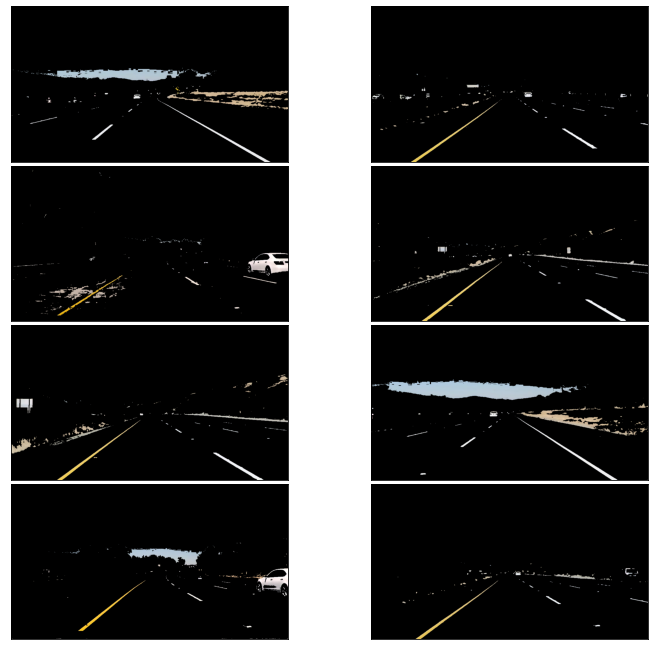

In [7]:
list_images(list(map(RGB_color_selection, test_images)))

### a) HSV color space

**Wikipedia**: HSV is an alternative representation of the RGB color model. The HSV representation models the way colors mix together, with the saturation dimension resembling various shades of brightly colored paint, and the value dimension resembling the mixture of those paints with varying amounts of black or white.

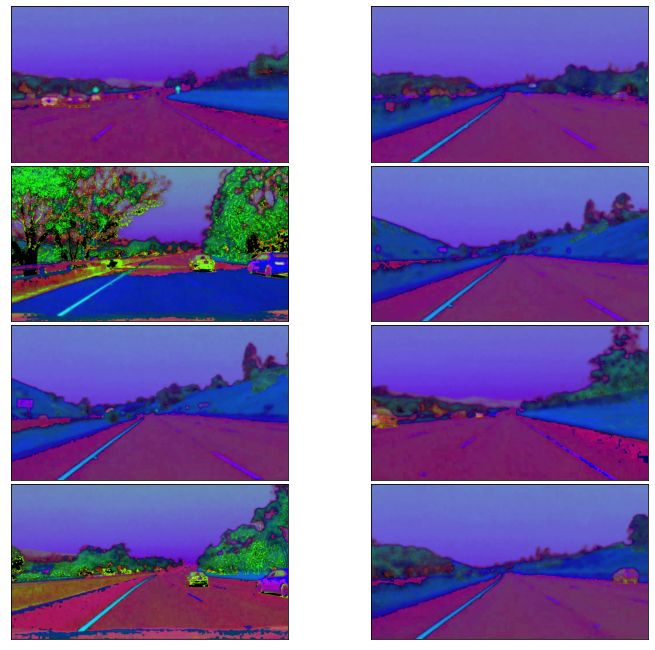

In [8]:
def convert_hsv(image):
    """
    Convert RGB images to HSV.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

list_images(list(map(convert_hsv, test_images)))

In [9]:
def HSV_color_selection(image):
    """
    Apply color selection to the HSV images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #Convert the input image to HSV
    converted_image = convert_hsv(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 0, 210])
    upper_threshold = np.uint8([255, 30, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([18, 80, 80])
    upper_threshold = np.uint8([30, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

Applying color selection to `test_images` in the HSV color space.

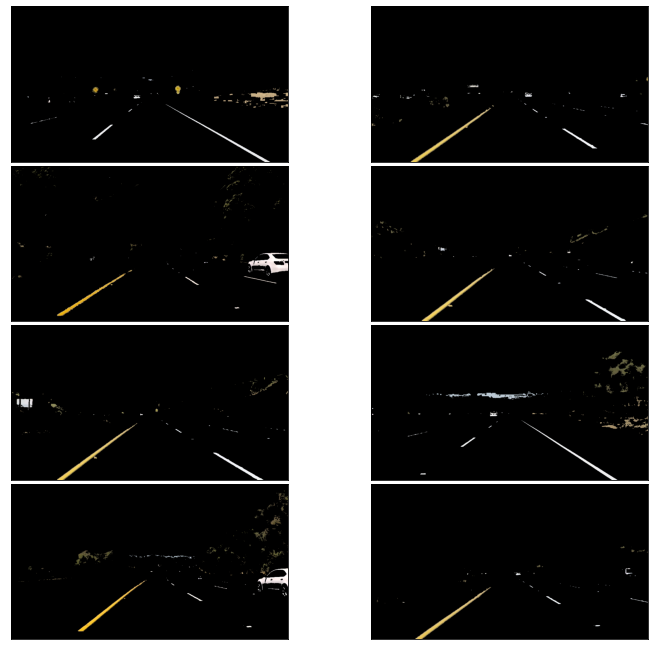

In [10]:
list_images(list(map(HSV_color_selection, test_images)))

### c) HSL color space

**Wikipedia**: HSL is an alternative representation of the RGB color model. The HSL model attempts to resemble more perceptual color models such as NCS or Munsell, placing fully saturated colors around a circle at a lightness value of 1/2, where a lightness value of 0 or 1 is fully black or white, respectively.

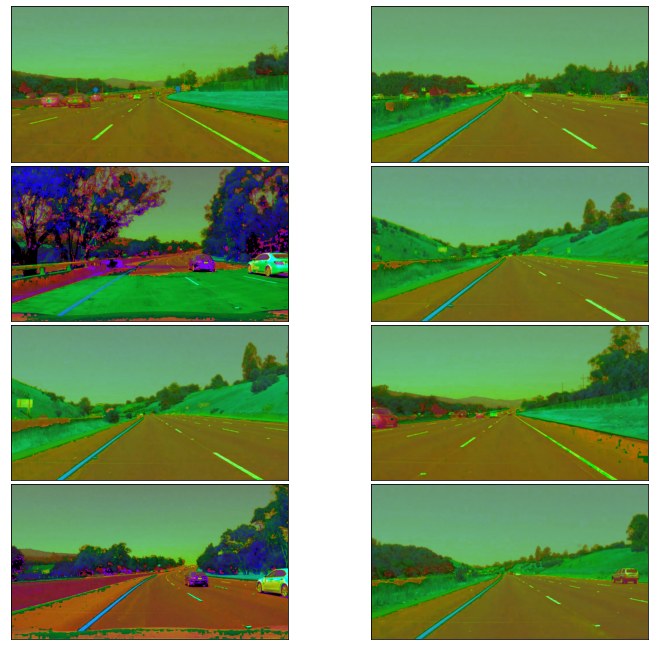

In [11]:
def convert_hsl(image):
    """
    Convert RGB images to HSL.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

list_images(list(map(convert_hsl, test_images)))

In [12]:
def HSL_color_selection(image):
    """
    Apply color selection to the HSL images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #Convert the input image to HSL
    converted_image = convert_hsl(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 200, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

Applying color selection to `test_images` in the HSL color space.

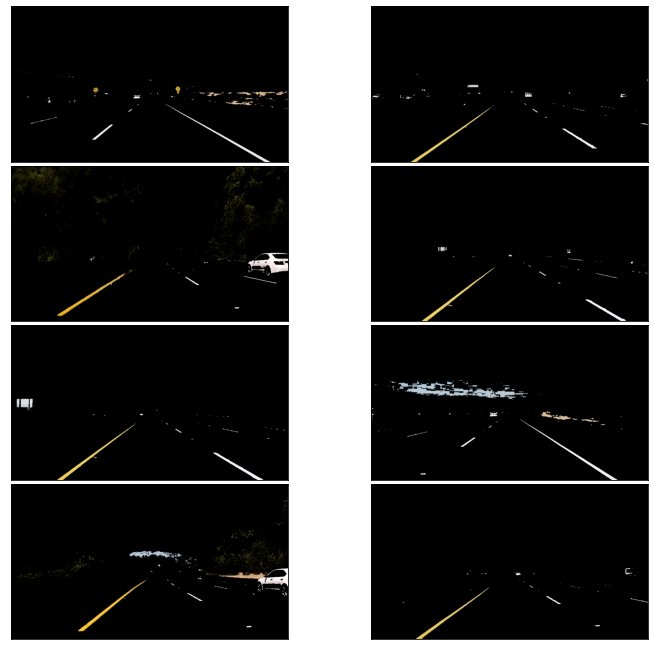

In [13]:
list_images(list(map(HSL_color_selection, test_images)))

Using HSL produces the clearest lane lines of all color spaces. We will use them for the next steps.

In [14]:
color_selected_images = list(map(HSL_color_selection, test_images))

### a) Gray scaling the images

The Canny edge detection algorithm measures the intensity gradients of each pixel. So, we need to convert the images into gray scale in order to detect edges.

In [15]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

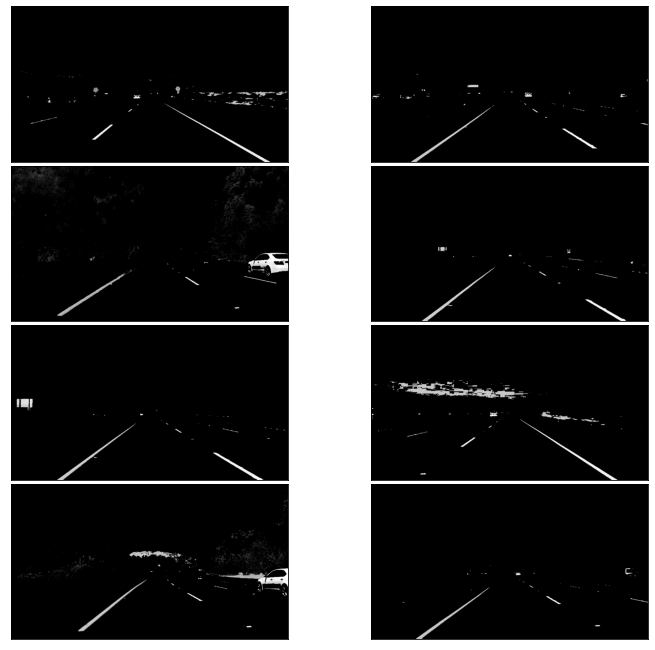

In [16]:
gray_images = list(map(gray_scale, color_selected_images))
list_images(gray_images)

### b) Applying Gaussian smoothing

**Wikipedia**: Since all edge detection results are easily affected by image noise, it is essential to filter out the noise to prevent false detection caused by noise. To smooth the image, a Gaussian filter is applied to convolve with the image. This step will slightly smooth the image to reduce the effects of obvious noise on the edge detector.

In [17]:
def gaussian_smoothing(image, kernel_size = 13):
    """
    Apply Gaussian filter to the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            kernel_size (Default = 13): The size of the Gaussian kernel will affect the performance of the detector.
            It must be an odd number (3, 5, 7, ...).
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

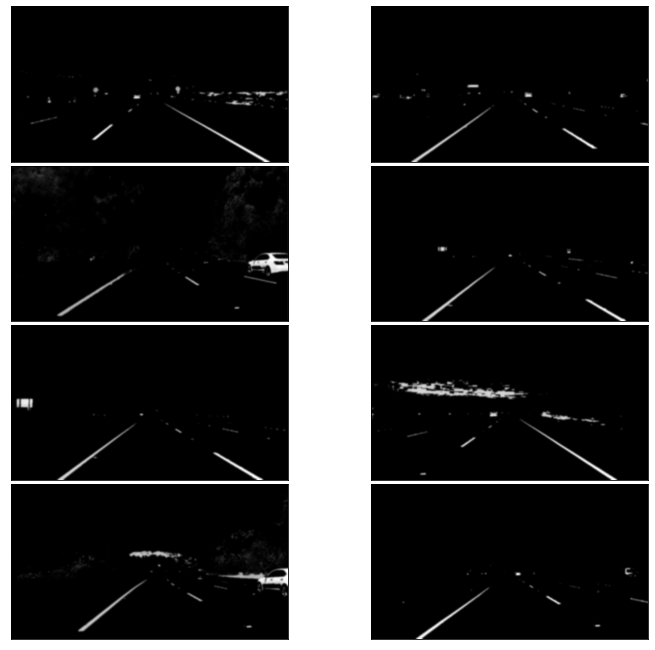

In [18]:
blur_images = list(map(gaussian_smoothing, gray_images))
list_images(blur_images)

### c) Applying Canny Edge Detection

**Wikipedia**:
The Process of Canny edge detection algorithm can be broken down to 5 different steps:
1. Find the intensity gradients of the image
2. Apply non-maximum suppression to get rid of spurious response to edge detection.
3. Apply *double threshold* to determine potential edges.
4. Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.

**If an edge pixel’s gradient value is higher than the high threshold value, it is marked as a strong edge pixel. If an edge pixel’s gradient value is smaller than the high threshold value and larger than the low threshold value, it is marked as a weak edge pixel. If an edge pixel's value is smaller than the low threshold value, it will be suppressed.
The two threshold values are empirically determined and their definition will depend on the content of a given input image.*

In [19]:
def canny_detector(image, low_threshold = 50, high_threshold = 150):
    """
    Apply Canny Edge Detection algorithm to the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            low_threshold (Default = 50).
            high_threshold (Default = 150).
    """
    return cv2.Canny(image, low_threshold, high_threshold)

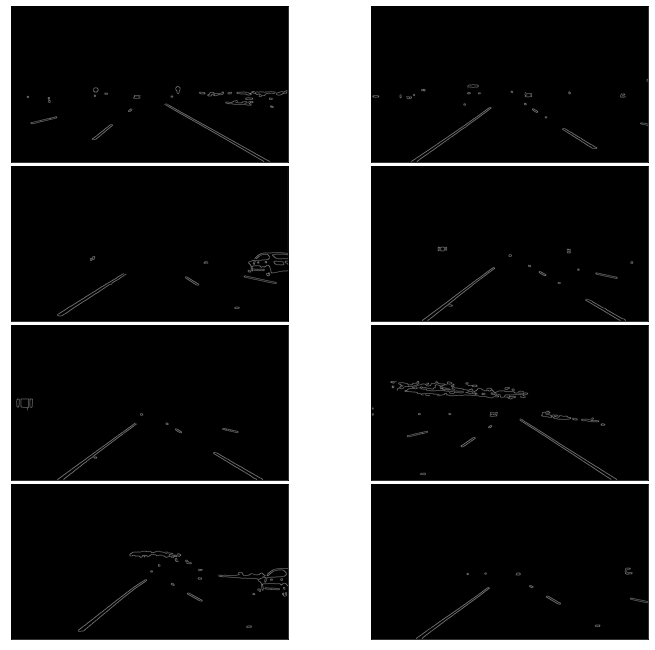

In [20]:
edge_detected_images = list(map(canny_detector, blur_images))
list_images(edge_detected_images)

## 4. Region of interest

We're interested in the area facing the camera, where the lane lines are found. So, we'll apply region masking to cut out everything else.

In [21]:
def region_selection(image):
    """
    Determine and cut the region of interest in the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    mask = np.zeros_like(image)   
    #Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #We could have used fixed numbers as the vertices of the polygon,
    #but they will not be applicable to images with different dimesnions.
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

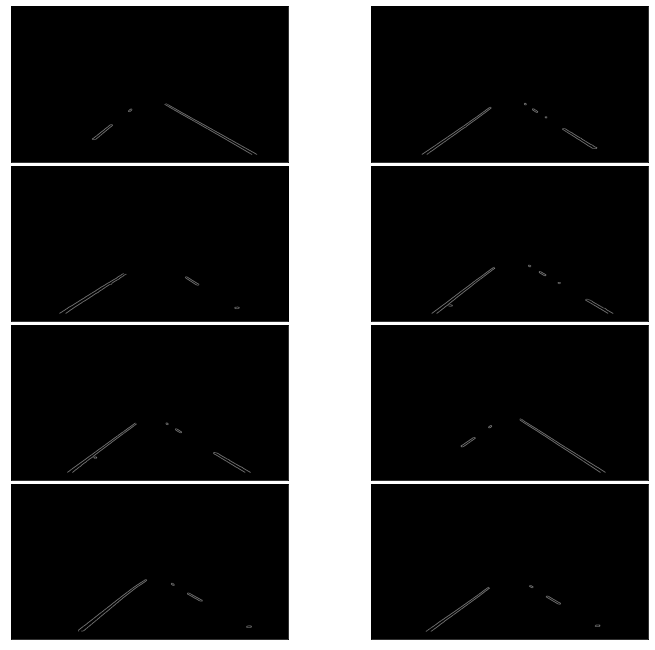

In [22]:
masked_image = list(map(region_selection, edge_detected_images))
list_images(masked_image)

## 5. Hough Transform

The Hough transform is a technique which can be used to isolate features of a particular shape within an image. I'll use it to detected the lane lines in `selected_region_images`.

In [23]:
def hough_transform(image):
    """
    Determine and cut the region of interest in the input image.
        Parameters:
            image: The output of a Canny transform.
    """
    rho = 1              #Distance resolution of the accumulator in pixels.
    theta = np.pi/180    #Angle resolution of the accumulator in radians.
    threshold = 20       #Only lines that are greater than threshold will be returned.
    minLineLength = 20   #Line segments shorter than that are rejected.
    maxLineGap = 300     #Maximum allowed gap between points on the same line to link them
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

`hough_lines` contains the list of lines detected in the selected region. Now, we will draw these detected lines onto the original `test_images`.

In [24]:
hough_lines = list(map(hough_transform, masked_image))

In [25]:
def draw_lines(image, lines, color = [255, 0, 0], thickness = 2):
    """
    Draw lines onto the input image.
        Parameters:
            image: An np.array compatible with plt.imshow.
            lines: The lines we want to draw.
            color (Default = red): Line color.
            thickness (Default = 2): Line thickness.
    """
    image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

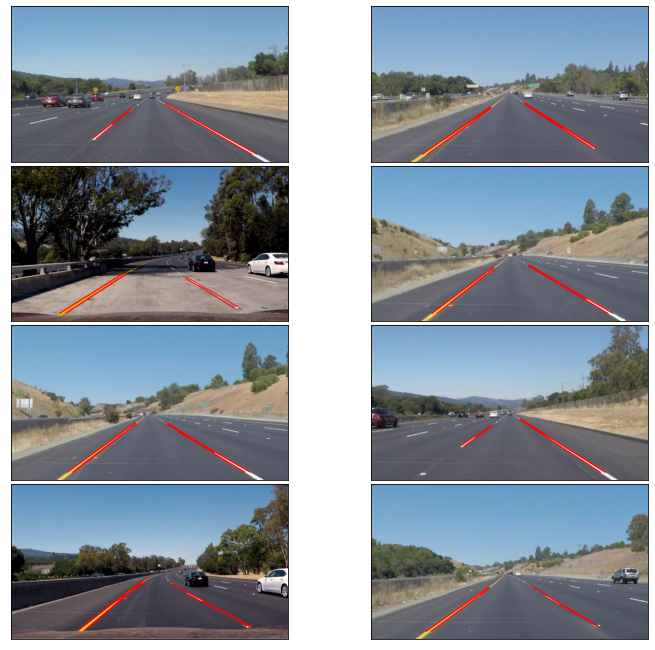

In [26]:
line_images = []
for image, lines in zip(test_images, hough_lines):
    line_images.append(draw_lines(image, lines))
    
list_images(line_images)

## 6. Averaging and extrapolating the lane lines

We have multiple lines detected for each lane line. We need to average all these lines and draw a single line for each lane line.
We also need to extrapolate the lane lines to cover the full lane line length.

In [27]:
def average_slope_intercept(lines):
    """
    Find the slope and intercept of the left and right lanes of each image.
        Parameters:
            lines: The output lines from Hough Transform.
    """
    left_lines    = [] #(slope, intercept)
    left_weights  = [] #(length,)
    right_lines   = [] #(slope, intercept)
    right_weights = [] #(length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

In [28]:
def pixel_points(y1, y2, line):
    """
    Converts the slope and intercept of each line into pixel points.
        Parameters:
            y1: y-value of the line's starting point.
            y2: y-value of the line's end point.
            line: The slope and intercept of the line.
    """
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

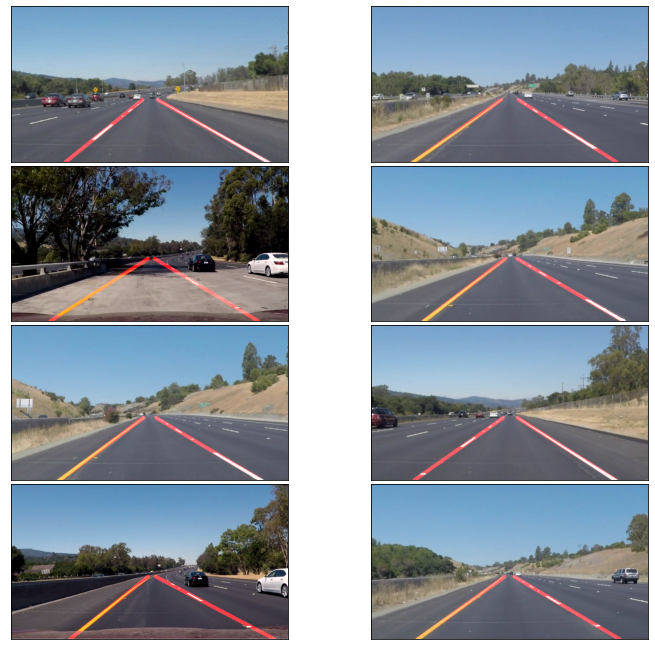

In [29]:
def lane_lines(image, lines):
    """
    Create full lenght lines from pixel points.
        Parameters:
            image: The input test image.
            lines: The output lines from Hough Transform.
    """
    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line  = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
    """
    Draw lines onto the input image.
        Parameters:
            image: The input test image.
            lines: The output lines from Hough Transform.
            color (Default = red): Line color.
            thickness (Default = 12): Line thickness. 
    """
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)
             
    
lane_images = []
for image, lines in zip(test_images, hough_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

    
list_images(lane_images)

## 7. Apply on video streams

Now, we'll use the above functions to detect lane lines from a video stream.

In [30]:
#Import everything needed to edit/save/watch video clips
from moviepy import *
from IPython.display import HTML
from IPython.display import Image

In [31]:
def frame_processor(image):
    """
    Process the input frame to detect lane lines.
        Parameters:
            image: Single video frame.
    """
    color_select = HSL_color_selection(image)
    gray         = gray_scale(color_select)
    smooth       = gaussian_smoothing(gray)
    edges        = canny_detector(smooth)
    region       = region_selection(edges)
    hough        = hough_transform(region)
    result       = draw_lane_lines(image, lane_lines(image, hough))
    return result 

In [32]:
def process_video(test_video, output_video):
    """
    Read input video stream and produce a video file with detected lane lines.
        Parameters:
            test_video: Input video.
            output_video: A video file with detected lane lines.
    """
    input_video = VideoFileClip(os.path.join('test_videos', test_video), audio=False)
    processed = input_video.fl_image(frame_processor)
    processed.write_videofile(os.path.join('output_videos', output_video), audio=False)

In [33]:
%time process_video('solidWhiteRight.mp4', 'solidWhiteRight_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\solidWhiteRight_output.mp4"))

Moviepy - Building video output_videos/solidWhiteRight_output.mp4.
Moviepy - Writing video output_videos/solidWhiteRight_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos/solidWhiteRight_output.mp4
CPU times: user 5.46 s, sys: 994 ms, total: 6.45 s
Wall time: 6.64 s


In [34]:
%time process_video('solidYellowLeft.mp4', 'solidYellowLeft_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\solidYellowLeft_output.mp4"))

Moviepy - Building video output_videos/solidYellowLeft_output.mp4.
Moviepy - Writing video output_videos/solidYellowLeft_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos/solidYellowLeft_output.mp4
CPU times: user 17.6 s, sys: 3.25 s, total: 20.9 s
Wall time: 21.4 s


In [ ]:
%time process_video('challenge.mp4', 'challenge_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\challenge_output.mp4"))

Moviepy - Building video output_videos/challenge_output.mp4.
Moviepy - Writing video output_videos/challenge_output.mp4



t:  35%|███▍      | 87/251 [00:03<00:08, 19.48it/s, now=None]